# Perform evaluations of the new supplementary models

We generate PR curves of the training and testing data and accuracy scores across hearts comparing between the actin only or rest only models.

## Import libraries

In [1]:
import pathlib
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import load
from sklearn.metrics import precision_recall_curve, auc

sys.path.append("../../utils")
from eval_utils import (
    generate_confusion_matrix_df,
    generate_f1_score_df,
    generate_accuracy_score_df,
)
from training_utils import get_X_y_data

## Set paths, variables, and dictionary with the models

In [2]:
# Directory with datasets
data_dir = pathlib.Path("../0.train_logistic_regression/data")

# Directory with models
models_dir = pathlib.Path("../0.train_logistic_regression/models/supp_models")

# Path to encoder file
encoder_path = pathlib.Path(
    "../0.train_logistic_regression/encoder_results/label_encoder_log_reg_fs_plate_4.joblib"
)


# Define the subdirectory for this plot type within fig_dir
supp_model_fig_dir = pathlib.Path("./figures/supp_model_figures")
supp_model_fig_dir.mkdir(parents=True, exist_ok=True)  # Create subdirectory if it doesn't exist

# Directory for result outputs (accuracy scores)
results_dir = pathlib.Path("./results")
results_dir.mkdir(exist_ok=True)

# Metadata column used for prediction class
label = "Metadata_cell_type"

# Initialize the dictionary to store models by category and type
loaded_models = {}

# Loop through all files in the models directory and load the ones that start with 'actin' or 'rest'
for model_path in models_dir.glob("*downsample.joblib"):
    if "actin" in model_path.name or "rest" in model_path.name:
        # Load the model
        model = load(model_path)

        # Determine model category (actin or rest) and type (final or shuffled)
        category = "actin" if "actin" in model_path.name else "rest"
        model_type = "final" if "final" in model_path.name else "shuffled"

        # Create a key combining category and model type
        model_key = f"{category}_{model_type}"

        # If the key doesn't exist in the dictionary, initialize an empty list
        if model_key not in loaded_models:
            loaded_models[model_key] = []

        # Append a dictionary containing the model and its path to the list
        loaded_models[model_key].append({
            "model": model,
            "model_path": model_path
        })

        print(f"Loaded model: {model_path.name} as {model_key}")

Loaded model: actin_shuffled_downsample.joblib as actin_shuffled
Loaded model: actin_final_downsample.joblib as actin_final
Loaded model: rest_shuffled_downsample.joblib as rest_shuffled
Loaded model: rest_final_downsample.joblib as rest_final


## Extract precision and recall data from the data splits

In [7]:
# Initialize empty lists to store data for each iteration
precision_list = []
recall_list = []
threshold_list = []
model_type_list = []
data_type_list = []
feature_set_list = []

# Loop through the dictionary of models (actin_final, actin_shuffled, etc.)
for category, models in loaded_models.items():
    # Extract model type from the category (actin_final -> final, actin_shuffled -> shuffled, etc.)
    model_type = category.split("_")[1]

    # Extract feature set from the first part of the category (actin or rest)
    feature_set = category.split("_")[0]

    # Iterate through each model in the current category (actin or rest)
    for model_info in models:
        model = model_info["model"]  # Access the model object from the dictionary

        print(f"Evaluating {model_type} model in {category} category...")

        # Iterate through datasets in the data directory
        for data_path in data_dir.iterdir():
            print(f"Applying {model_type} to {data_path.stem}...")

            # Load in label encoder
            le = load(encoder_path)

            # Load in data being evaluated
            split_df = pd.read_csv(data_path)

            # Separate metadata columns
            metadata_columns = [
                col for col in split_df.columns if col.startswith("Metadata_")
            ]

            # Separate features columns (filtering out features containing both "Correlation" and "Actin")
            filtered_columns = [
                col
                for col in split_df.columns
                if not col.startswith("Metadata_")
                and not ("Actin" in col and "Correlation" in col)
            ]

            # Now split into Actin and non-Actin features based on model category
            if feature_set == "actin":
                features_columns = [col for col in filtered_columns if "Actin" in col]
            else:
                features_columns = [
                    col for col in filtered_columns if "Actin" not in col
                ]

            # Create the new updated dataframe with the correct features
            updated_split_df = split_df[metadata_columns + features_columns]

            # Get X and y data from the dataframe
            X, y = get_X_y_data(df=updated_split_df, label=label, shuffle=False)

            # Assign y classes to correct binary using label encoder results
            y_binary = le.transform(y)

            # Predict class probabilities for morphology feature data
            predicted_probs = model.predict_proba(X)

            # Calculate the precision, recall data
            precision, recall, threshold = precision_recall_curve(
                y_binary, predicted_probs[:, -1]
            )
            threshold = np.append(threshold, np.nan)

            # Append data to lists
            precision_list.extend(precision.tolist())
            recall_list.extend(recall.tolist())
            threshold_list.extend(threshold.tolist())
            model_type_list.extend([model_type] * len(precision))
            data_type_list.extend([data_path.stem.split("_")[0]] * len(precision))
            feature_set_list.extend(
                [feature_set] * len(precision)
            )  # Append feature set

Evaluating shuffled model in actin_shuffled category...
Applying shuffled to testing_data...
Applying shuffled to holdout2_data...
Applying shuffled to holdout1_data...


/tmp/ipykernel_95789/651589171.py:31: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  split_df = pd.read_csv(data_path)


Applying shuffled to training_data...
Evaluating final model in actin_final category...
Applying final to testing_data...
Applying final to holdout2_data...
Applying final to holdout1_data...


/tmp/ipykernel_95789/651589171.py:31: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  split_df = pd.read_csv(data_path)


Applying final to training_data...
Evaluating shuffled model in rest_shuffled category...
Applying shuffled to testing_data...
Applying shuffled to holdout2_data...
Applying shuffled to holdout1_data...


/tmp/ipykernel_95789/651589171.py:31: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  split_df = pd.read_csv(data_path)


Applying shuffled to training_data...
Evaluating final model in rest_final category...
Applying final to testing_data...
Applying final to holdout2_data...
Applying final to holdout1_data...


/tmp/ipykernel_95789/651589171.py:31: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  split_df = pd.read_csv(data_path)


Applying final to training_data...
(67440, 6)


,Precision,Recall,Threshold,Model_Type,Data_Type,Feature_Set
0,0.374428,1.0,0.254421,shuffled,testing,actin
1,0.374529,1.0,0.316670,shuffled,testing,actin
2,0.374630,1.0,0.360479,shuffled,testing,actin
3,0.374731,1.0,0.371956,shuffled,testing,actin
4,0.374832,1.0,0.372068,shuffled,testing,actin


## Create dataframe with PR data across data splits, model type, and model feature set

In [4]:
# Create a DataFrame from the accumulated data
pr_df = pd.DataFrame(
    {
        "Precision": precision_list,
        "Recall": recall_list,
        "Threshold": threshold_list,
        "Model_Type": model_type_list,
        "Data_Type": data_type_list,
        "Feature_Set": feature_set_list,
    }
)

# Drop any NA data
pr_df.dropna(inplace=True)

# Show output of all data
print(pr_df.shape)
pr_df.head()

(67440, 6)


,Precision,Recall,Threshold,Model_Type,Data_Type,Feature_Set
0,0.374428,1.0,0.254421,shuffled,testing,actin
1,0.374529,1.0,0.316670,shuffled,testing,actin
2,0.374630,1.0,0.360479,shuffled,testing,actin
3,0.374731,1.0,0.371956,shuffled,testing,actin
4,0.374832,1.0,0.372068,shuffled,testing,actin


## Create PR curve plot for the training and testing data for `actin only` model

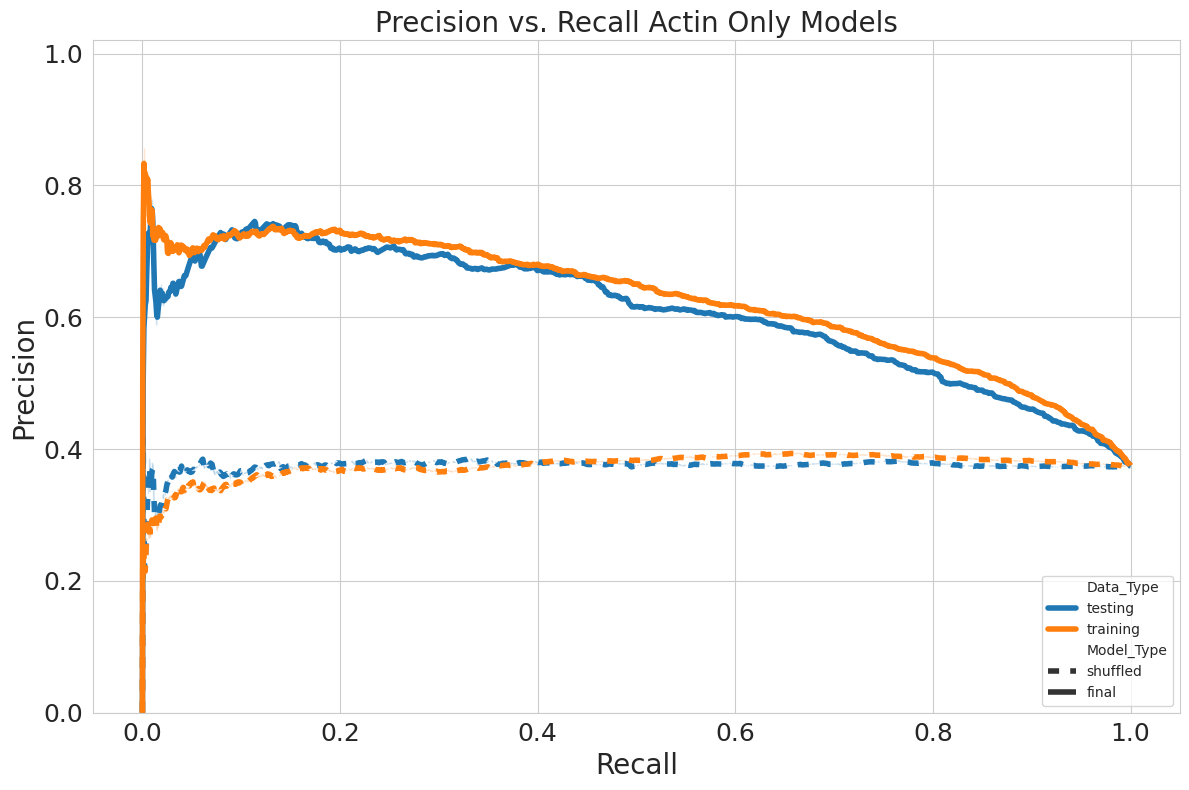

In [5]:
# PR curves with only testing and training data and actin feature set
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Filter the dataframe to only include 'training' and 'testing' data types,
# and where the feature_set is 'actin'
filtered_df = pr_df[
    (pr_df["Data_Type"].isin(["training", "testing"]))
    & (pr_df["Feature_Set"] == "actin")
]

# Create a line plot for Precision vs Recall
sns.lineplot(
    x="Recall",
    y="Precision",
    hue="Data_Type",  # Differentiate based on Data_Type (training vs testing)
    style="Model_Type",  # Differentiate line styles based on Model_Type
    dashes={
        "final": (1, 0),
        "shuffled": (2, 2),
    },  # Custom dash patterns for final and shuffled
    data=filtered_df,
    linewidth=4,  # Adjust the line width as needed
)

# Set legend location
plt.legend(loc="lower right")

# Set plot limits for y-axis
plt.ylim(bottom=0.0, top=1.02)

# Set x and y axis labels with larger font
plt.xlabel("Recall", fontsize=20)
plt.ylabel("Precision", fontsize=20)

# Set plot title with larger font
plt.title("Precision vs. Recall Actin Only Models", fontsize=20)

# Adjust font size for x-axis and y-axis ticks
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Adjust layout to prevent clipping
plt.tight_layout()

# Save the plot
plt.savefig(f"{supp_model_fig_dir}/actin_model_precision_recall_plate4_downsample.png", dpi=500, bbox_inches='tight')

plt.show()

In [6]:
# Filter the dataframe for the final actin features only model using the original pr_df
final_model_df = pr_df[
    (pr_df["Model_Type"] == "final") & (pr_df["Feature_Set"] == "actin")
]

# Calculate AUPRC for training data
training_data = final_model_df[final_model_df["Data_Type"] == "training"]
training_auprc = auc(training_data["Recall"], training_data["Precision"])

# Calculate AUPRC for testing data
testing_data = final_model_df[final_model_df["Data_Type"] == "testing"]
testing_auprc = auc(testing_data["Recall"], testing_data["Precision"])

# Output the results
print(f"AUPRC for Training Data: {training_auprc:.4f}")
print(f"AUPRC for Testing Data: {testing_auprc:.4f}")

AUPRC for Training Data: 0.6266
AUPRC for Testing Data: 0.6076


## Create PR curve plot for the training and testing data for `rest only` model

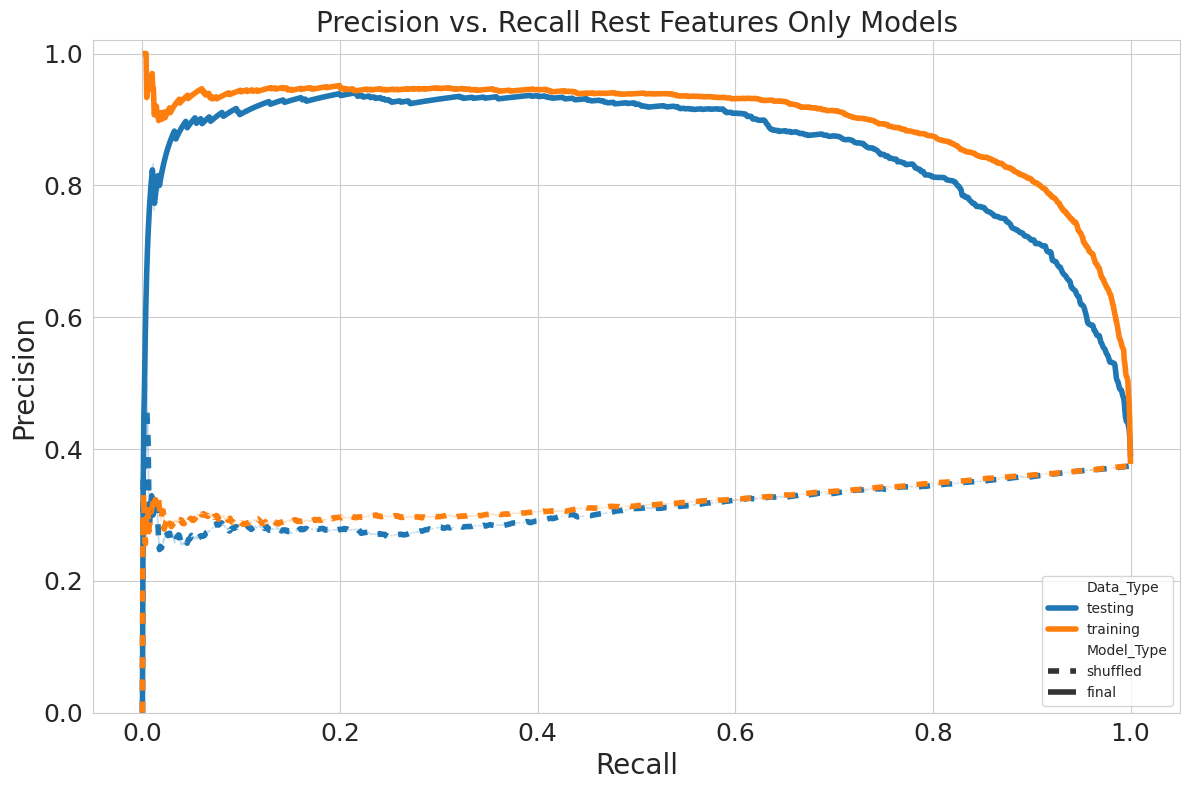

In [7]:
# PR curves with only testing and training data and actin feature set
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Filter the dataframe to only include 'training' and 'testing' data types,
# and where the feature_set is 'rest'
filtered_df = pr_df[
    (pr_df["Data_Type"].isin(["training", "testing"]))
    & (pr_df["Feature_Set"] == "rest")
]

# Create a line plot for Precision vs Recall
sns.lineplot(
    x="Recall",
    y="Precision",
    hue="Data_Type",  # Differentiate based on Data_Type (training vs testing)
    style="Model_Type",  # Differentiate line styles based on Model_Type
    dashes={
        "final": (1, 0),
        "shuffled": (2, 2),
    },  # Custom dash patterns for final and shuffled
    data=filtered_df,
    linewidth=4,  # Adjust the line width as needed
)

# Set legend location
plt.legend(loc="lower right")

# Set plot limits for y-axis
plt.ylim(bottom=0.0, top=1.02)

# Set x and y axis labels with larger font
plt.xlabel("Recall", fontsize=20)
plt.ylabel("Precision", fontsize=20)

# Set plot title with larger font
plt.title("Precision vs. Recall Rest Features Only Models", fontsize=20)

# Adjust font size for x-axis and y-axis ticks
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Adjust layout to prevent clipping
plt.tight_layout()

# Save the plot 
plt.savefig(f"{supp_model_fig_dir}/rest_model_precision_recall_plate4_downsample.png", dpi=500, bbox_inches='tight')

plt.show()

In [8]:
# Filter the dataframe for the final rest features only model using the original pr_df
final_model_df = pr_df[
    (pr_df["Model_Type"] == "final") & (pr_df["Feature_Set"] == "rest")
]

# Calculate AUPRC for training data
training_data = final_model_df[final_model_df["Data_Type"] == "training"]
training_auprc = auc(training_data["Recall"], training_data["Precision"])

# Calculate AUPRC for testing data
testing_data = final_model_df[final_model_df["Data_Type"] == "testing"]
testing_auprc = auc(testing_data["Recall"], testing_data["Precision"])

# Output the results
print(f"AUPRC for Training Data: {training_auprc:.4f}")
print(f"AUPRC for Testing Data: {testing_auprc:.4f}")

AUPRC for Training Data: 0.9008
AUPRC for Testing Data: 0.8608


## Create one PR curve for both models

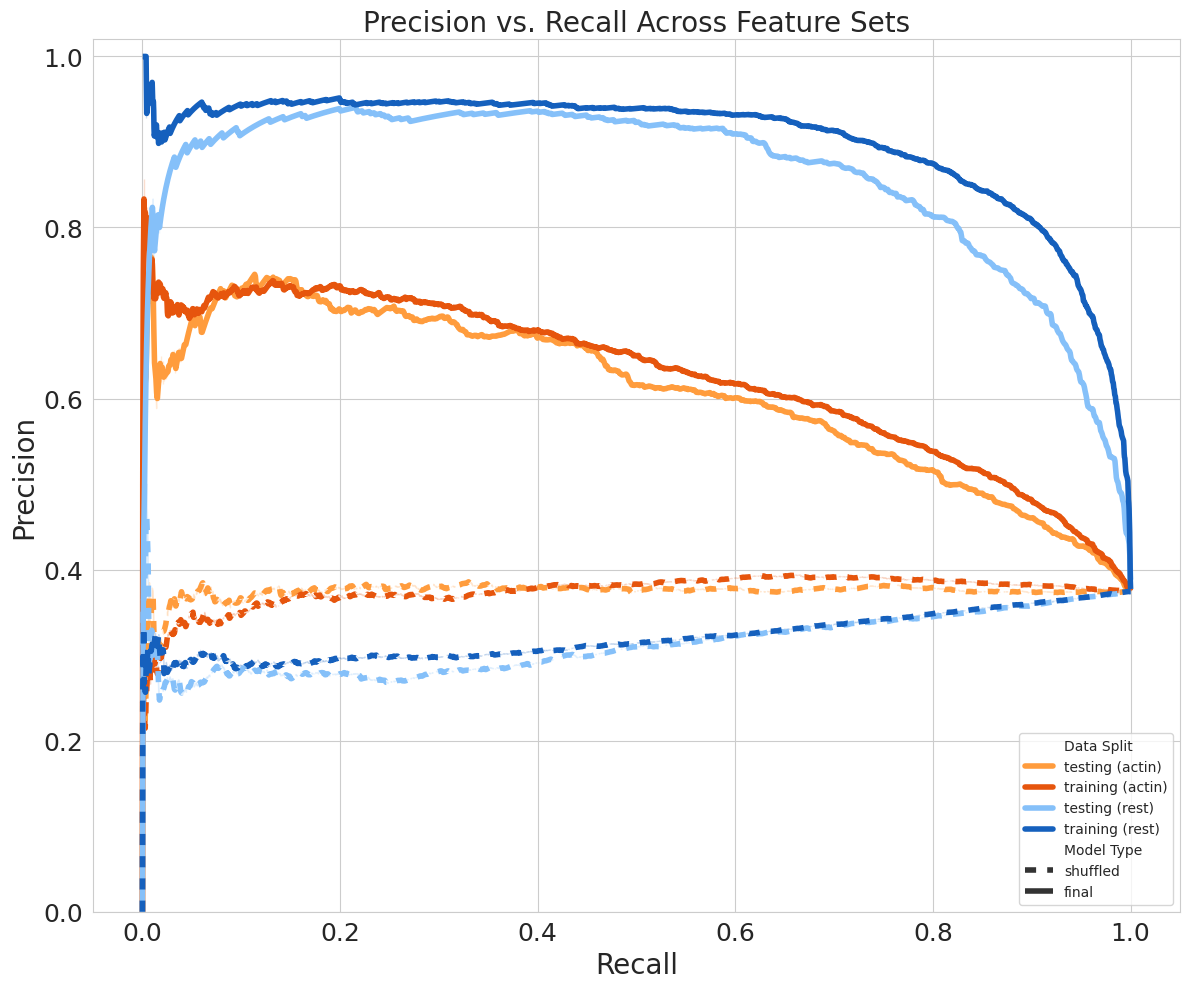

In [9]:
# Create a custom color palette: darker for training, lighter for testing
palette = {
    "training (rest)": "#1560bd",  # Darker blue
    "testing (rest)": "#85c0f9",   # Lighter blue
    "training (actin)": "#e6550d",   # Darker orange
    "testing (actin)": "#ff9c3d",    # Lighter orange
}

# PR curves with both training and testing data for all feature sets
plt.figure(figsize=(12, 10))
sns.set_style("whitegrid")

# Filter the dataframe to only include 'training' and 'testing' data types
filtered_df = pr_df[
    pr_df["Data_Type"].isin(["training", "testing"])
].copy()  # Make a copy of the filtered dataframe to avoid SettingWithCopyWarning

# Create a new column 'Data_Type_Feature' by combining Data_Type and Feature_Set
filtered_df['Data Split'] = filtered_df['Data_Type'] + ' (' + filtered_df['Feature_Set'] + ')'

# Rename the column 'Model_Type' to something else if needed
filtered_df = filtered_df.rename(columns={'Model_Type': 'Model Type'})

# Create a line plot for Precision vs Recall
sns.lineplot(
    x="Recall",
    y="Precision",
    hue="Data Split",  # Use the new combined column for hue
    style="Model Type",  # Differentiate line styles based on Model Type
    dashes={
        "final": (1, 0),
        "shuffled": (2, 2),
    },  # Custom dash patterns for final and shuffled
    data=filtered_df,
    linewidth=4,  # Adjust the line width as needed
    palette=palette,  # Apply the custom palette
)

# Set legend location
plt.legend(loc="lower right")

# Set plot limits for y-axis
plt.ylim(bottom=0.0, top=1.02)

# Set x and y axis labels with larger font
plt.xlabel("Recall", fontsize=20)
plt.ylabel("Precision", fontsize=20)

# Set plot title with larger font
plt.title("Precision vs. Recall Across Feature Sets", fontsize=20)

# Adjust font size for x-axis and y-axis ticks
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Adjust layout to prevent clipping
plt.tight_layout()

# Save the plot 
plt.savefig(f"{supp_model_fig_dir}/precision_recall_actin_versus_rest.pdf", dpi=500, bbox_inches='tight')

plt.show()

## Extract accuracy scores across data splits and hearts

In [10]:
# List of data sets to apply models to
data_set_list = ["training", "testing", "holdout1", "holdout2"]

# Metadata column used for classifying
label = "Metadata_cell_type"

# List to store accuracy dataframes for concatenation
accuracy_dfs = []

# Loop through the dictionary of models (e.g., actin_final, actin_shuffled)
for category, models in loaded_models.items():
    # Extract model type (e.g., final, shuffled)
    model_type = category.split("_")[1]

    # Extract feature set (e.g., actin, rest)
    feature_set = category.split("_")[0]

    # Iterate over each model in the current category
    for model_info in models:
        model_path = model_info["model_path"]
        print(f"Evaluating {model_type.capitalize()} model in {feature_set} feature set...")

        # Loop over each dataset
        for data_set in data_set_list:
            print(f"Applying {model_type.capitalize()} model to {data_set} dataset in {feature_set} feature set...")

            # Load the dataset
            data_path = data_dir / f"{data_set}_data.csv"
            data_df = pd.read_csv(data_path)

            # Separate metadata columns
            metadata_columns = [
                col for col in data_df.columns if col.startswith("Metadata_")
            ]

            # Separate features columns (filtering out features containing both "Correlation" and "Actin")
            filtered_columns = [
                col
                for col in data_df.columns
                if not col.startswith("Metadata_")
                and not ("Actin" in col and "Correlation" in col)
            ]

            # Now split into Actin and non-Actin features based on model category
            if feature_set == "actin":
                features_columns = [col for col in filtered_columns if "Actin" in col]
            else:
                features_columns = [
                    col for col in filtered_columns if "Actin" not in col
                ]

            # Create the new updated dataframe with the correct features
            updated_data_df = data_df[metadata_columns + features_columns]

            # Group the data by heart number
            grouped_data = updated_data_df.groupby("Metadata_heart_number")

            # Iterate over each group (heart number)
            for heart_number, df_heart in grouped_data:
                # Generate accuracy data frame
                accuracy_df = generate_accuracy_score_df(
                    model_path=model_path,
                    data_set=df_heart,
                    encoder_path=encoder_path,
                    label=label,
                )

                # Rename binary labels to Failing versus Healthy
                accuracy_df = accuracy_df.rename(columns={0: "Failing", 1: "Healthy"})

                # Add columns for model type, feature set, data set, and heart number
                accuracy_df["Model_Type"] = model_type.capitalize()
                accuracy_df["Feature_Set"] = feature_set.capitalize()
                accuracy_df["Data_Set"] = data_set.capitalize()
                accuracy_df["Heart_Number"] = heart_number

                # Append the DataFrame to the list
                accuracy_dfs.append(accuracy_df)

# Merge all of the accuracy scores across model type and data split
concat_accuracy_scores = pd.concat(accuracy_dfs, ignore_index=True)

# Save results for visualization
concat_accuracy_scores.to_csv(f"{results_dir}/actin_and_rest_accuracy_scores_per_heart.csv", index=False)

Evaluating Shuffled model in actin feature set...
Applying Shuffled model to training dataset in actin feature set...
Applying Shuffled model to testing dataset in actin feature set...
Applying Shuffled model to holdout1 dataset in actin feature set...


/tmp/ipykernel_78027/1524362378.py:29: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  data_df = pd.read_csv(data_path)


Applying Shuffled model to holdout2 dataset in actin feature set...
Evaluating Final model in actin feature set...
Applying Final model to training dataset in actin feature set...
Applying Final model to testing dataset in actin feature set...
Applying Final model to holdout1 dataset in actin feature set...


/tmp/ipykernel_78027/1524362378.py:29: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  data_df = pd.read_csv(data_path)


Applying Final model to holdout2 dataset in actin feature set...
Evaluating Shuffled model in rest feature set...
Applying Shuffled model to training dataset in rest feature set...
Applying Shuffled model to testing dataset in rest feature set...
Applying Shuffled model to holdout1 dataset in rest feature set...


/tmp/ipykernel_78027/1524362378.py:29: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  data_df = pd.read_csv(data_path)


Applying Shuffled model to holdout2 dataset in rest feature set...
Evaluating Final model in rest feature set...
Applying Final model to training dataset in rest feature set...
Applying Final model to testing dataset in rest feature set...
Applying Final model to holdout1 dataset in rest feature set...
Applying Final model to holdout2 dataset in rest feature set...


/tmp/ipykernel_78027/1524362378.py:29: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  data_df = pd.read_csv(data_path)


## Create bar plot of the accuracies across hearts and data splits and the model type (actin or rest)

<Figure size 1600x1200 with 0 Axes>

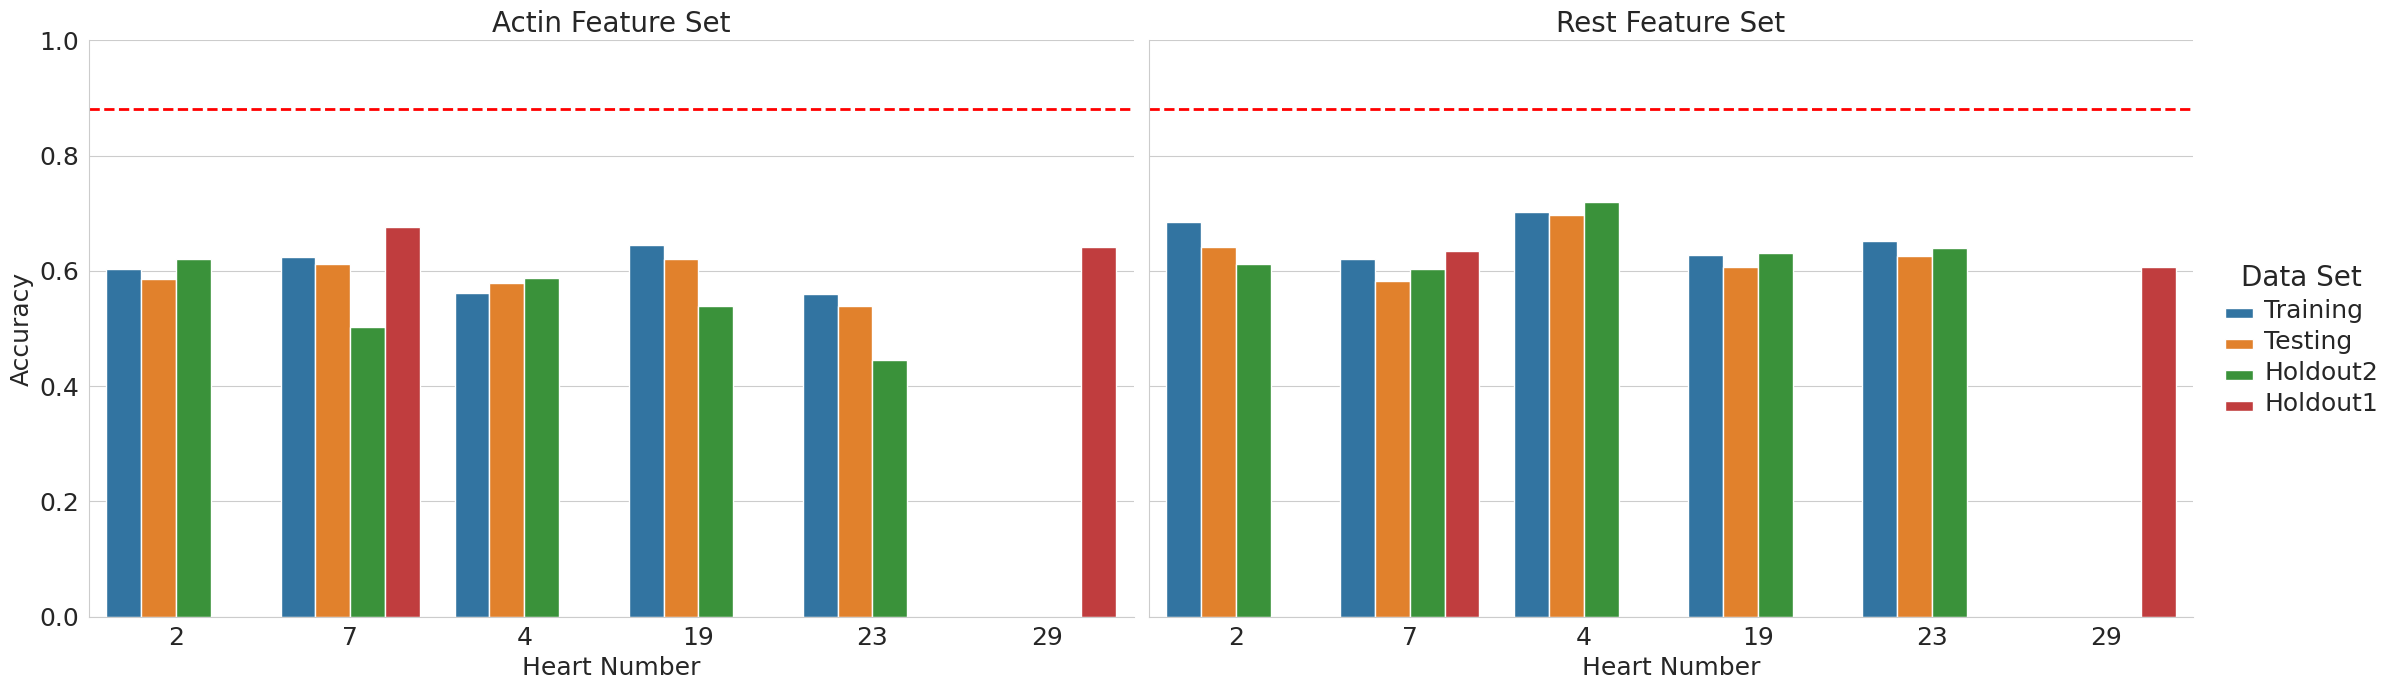

In [11]:
# Set the order for Heart_Number
heart_order = [2, 7, 4, 19, 23, 29]

# Set a taller plot size for the overall figure
plt.figure(figsize=(16, 12))  

# Create a seaborn catplot with facetting by Feature_Set
g = sns.catplot(
    x='Heart_Number',  # Heart_Number on the x-axis
    y='Accuracy',  # Accuracy on the y-axis (replace with the actual column name for accuracy scores)
    hue='Data_Set',  # Data_Set as the hue
    col='Feature_Set',  # Facet by Feature_Set
    data=concat_accuracy_scores,
    kind='bar',  # Specify the type of plot (bar plot)
    errorbar=None,  # Disable confidence intervals if you don't need them
    height=7,  # Increase the height of each facet
    aspect=1.5,  # Aspect ratio to make the plots wider
    order=heart_order,  # Specify the order of Heart_Number on the x-axis
)

# Customize the axis labels, titles, and ticks with larger font sizes
g.set_axis_labels('Heart Number', 'Accuracy')  # Set axis labels for all facets
g.set_titles(col_template="{col_name} Feature Set", size=20)
g.set_xlabels("Heart Number", fontsize=18)
g.set_ylabels("Accuracy", fontsize=18)

# Set the y-axis limits and customize tick label sizes for all axes
for ax in g.axes.flat:
    ax.set_ylim(0, 1)
    ax.axhline(0.88, color='r', linestyle='--', linewidth=2) # average accuracy of final all feature models across hearts and splits
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18) 

# Customize the legend font size and location
g.legend.set_bbox_to_anchor((1.08, 0.5))  # Move legend outside of the plot
g.legend.set_title('Data Set', prop={'size': 20})
for text in g.legend.texts:
    text.set_fontsize(18) 

# Adjust the layout to ensure everything fits
plt.tight_layout()

# Save the plot with a little extra padding around the figure
plt.savefig(f"{supp_model_fig_dir}/rest_versus_actin_model_accuracy_hearts.png", dpi=500, bbox_inches='tight')

# Show the plot
plt.show()

## Find the top feature to predicting failing cells from rest final model

In [12]:
# Load the training data
data_path = "../0.train_logistic_regression/data/training_data.csv"
data = pd.read_csv(data_path)

# Filter out columns based on the conditions
feature_columns = [
    col for col in data.columns
    if not col.startswith("Metadata_") and not ("Actin" in col and "Correlation" in col)
]

# Remove columns containing 'Actin'
feature_columns = [col for col in feature_columns if "Actin" not in col]

# Print the filtered feature columns
print(f"Length of feature columns: {len(feature_columns)}")


Length of feature columns: 544


In [13]:
# Retrieve the 'rest_final' model from the dictionary
rest_final_model_info = loaded_models.get("rest_final", None)

if rest_final_model_info:
    # Extract the model from the dictionary (assuming only one entry exists)
    rest_final_model = rest_final_model_info[0]["model"]
    model_path = rest_final_model_info[0]["model_path"]
    print(f"Using model: {rest_final_model} from path: {model_path}")

    # Get the coefficients
    coefficients = rest_final_model.coef_

    # Print the coefficients shape
    print(f"Coefficients shape: {coefficients.shape}")

    # Confirm the coefficients match the feature columns
    if coefficients.shape[1] == len(feature_columns):
        print("The number of coefficients matches the number of feature columns.")
    else:
        print("Warning: The number of coefficients does not match the number of feature columns.")

    # Create a DataFrame with the coefficients and features
    coefficients_df = pd.DataFrame({"Feature": feature_columns, "Coefficient": coefficients.flatten()})

    # Find the row with the most negative or lowest coefficient
    lowest_coefficient_row = coefficients_df.loc[coefficients_df['Coefficient'].idxmin()]

    # Print the lowest row
    print("Row with the most negative coefficient:")
    print(lowest_coefficient_row)
    
else:
    print("No 'rest_final' model found in the dictionary.")

Using model: LogisticRegression(C=0.1, class_weight='balanced', l1_ratio=0.4, max_iter=1000,
                   n_jobs=-1, penalty='elasticnet', random_state=0,
                   solver='saga') from path: ../0.train_logistic_regression/models/supp_models/rest_final_downsample.joblib
Coefficients shape: (1, 544)
The number of coefficients matches the number of feature columns.
Row with the most negative coefficient:
Feature        Nuclei_Correlation_RWC_ER_Hoechst
Coefficient                            -0.799654
Name: 393, dtype: object
